# PCA: Свой jpeg с блекджеком  и куртизантками

<img src='https://cs.pikabu.ru/post_img/2013/08/07/10/1375893075_408844834.jpg' width=400>

### 1. Как работает jpeg: в двух словах

Все изображение делится на квадраты 8х8 а затем каждый кусочек представляется в виде суммы из базисных кусочков 
(базисных векторов фурье-преобразования). 
Выбор именно такого базиса обусловлен универсальностью, но не обязательно наиболее выгоден для того или иного изображения. 

Выглядят базисные вектора jpeg вот так:
<img src='https://upload.wikimedia.org/wikipedia/commons/2/24/DCT-8x8.png' width=300>

Для тех кто хочет подробнее https://habrahabr.ru/post/206264/

(На самом деле там есть еще несколько этапов но нас интересует именно разложение в базис)

### 2. Задание
В качестве интересного способа практического применения PCA предлагаю вам сделать разложение на вектора, оптимальные для конкретного изображения (или набора изображений). Эти вектора мы можем легко получить, воспользовавшись SVD разложением.

Схема следующая:

Входные параметры - размер кусочков $n$ количество базисных векторов $d$
1. Разбиваем изображение на кусочки $n\times n$. всего получим $q=\frac{width*height}{n^2}$ кусочков
2. К каждому кусочку применяем `np.array.flatten()`. В итогe получаем матрицу $X$ размера $n^2\times q$
3. Делаем PCA, оставляем только $d$ компонент с наибольшими собственными значениями, получаем матрицу $d \times q$.(см код семинара)
4. Получившиеся вектора размера d переводим обратно в пространство размерности $n^2$ (см. код семинара)
5. применяем `numpy.reshape((n,n))`, cклеиваем кусочки обратно в том же порядке, что и разбивали
6. Выводим картинку и наслаждаемся результатом.
6. Визуализируем базисные вектора и сравниваем с джипеговскими (функция для визуализации прилагается)

Во время выполнения задания следите за размерностями матриц, чтоб избежать ошибок

### 3. Эксперименты
1. Посмотреть как меняется энтропия изображения и какая степень сжатия
2. Найти оптимальный размер $n$ и количество векторов $d$ 
3. Сравнить такой способ сжатия с <a href="https://docs.python.org/2/library/jpeg.html">jpeg</a>
4. Вычесть из исходного изображения сжатое, чтоб посмотреть какие пиксели отличаются.


### 4. Идеи для дальнейшего развития
1. Что если делить на маленькие квадраты, сжимать их не очень сильно, а получившиеся вектора меньшей размерности соединять в "большие квадраты" и к ним еще раз применять PCA (а потом еще раз и еще раз)?
2. Что если в случае маленькой дисперсии объединять квадраты в один и раскладывать в базис уже его?
3. Что если сделать параметром не количество базисных векторов а пороговую дисперсию? Иными словами - выбирать $d$ в зависимости от дисперии кусочка.
4. Что если сверточные сети обучать на таком представлении (матрица $d \times q$)?

Если возникли какие-то сложности пишите мне http://t.me/danlkv http://vk.com/danilozzz

Если получилось реализовать что-то из идей тоже пишите, мне самому очень интересно что будет.

Успехов!

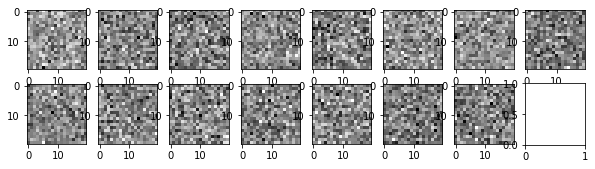

In [251]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images_table(imgs, columns=8):
    n=len(imgs)
    h = (n-1)//columns+1
    f,ax=plt.subplots(h,columns,figsize=(10,10*h/columns))
    for i in range(1,n+1):
        ax[(i-1)//columns,i%columns-1].imshow(imgs[i-1],cmap='gray')
        
tt = np.random.randn(15,20,20)
plot_images_table(tt)

In [252]:
import requests
from PIL import Image
from io import BytesIO
# функция скачивает изображение по ссылке
def get_image(url):
    print("making request")
    r = requests.get(url)
    strio = BytesIO(r.content)
    i = Image.open(strio)
    print("got image with size %s"%str(np.array(i).shape))
    return i

In [253]:
# Эту функцию можно очень просто модифицировать для идеи #3
def pca(X,num_components):
    X=np.array([l-np.mean(l) for l in X]) # Вычитаем среднее
    U,s,V=np.linalg.svd(X)                # Находим собственные вектора
    eps=np.sort(s)[-num_components]       # пороговое собственное значение (служебная строчка) 
    E = np.array([vec for val,vec in zip(s,V)
                  if val>eps])            # берем только важные вектора   (с большими собственными значениями)
    X_=np.dot(E,X.T).T                    # Преобразуем данные
    return X_,E

making request
got image with size (320, 480, 3)


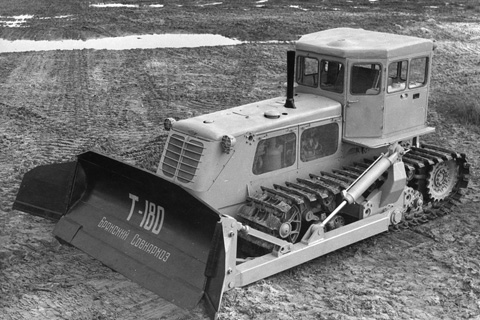

In [254]:
# Получаем изображение, разбиваем на кусочки
image = get_image('http://nacekomie.ru/forum/files/201609/48733_d8aa7f48130c6527da86057813fac926.jpg')
#image = get_image('http://bygaga.com.ua/uploads/posts/thumbs/1349628056_krasivaya-planeta-37.jpg')

np_image = np.asarray(image)

image

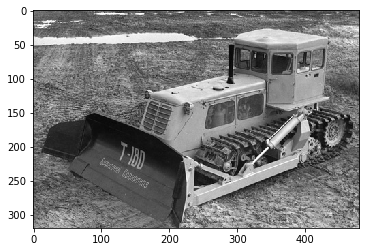

In [255]:
plt.imshow(np.mean(np_image,axis=2), cmap = 'gray')

In [256]:
n = 40
parts=[]

imgwidth, imgheight = image.size
for i in range(0,imgheight, n):
    for j in range(0,imgwidth, n):
        box = (j, i, j+n, i+n)
        a = image.crop(box)
        a = np.asarray(a)
        #a.flatten()
        parts.append(np.array(a))

In [257]:
parts = np.array(parts)

In [258]:
reconstr=[]
for a in parts:
    X  = np.mean(a,axis=2)
    T,E = pca(X,25)
    reconstr.append(np.dot(T,E))


In [260]:
# Переводим закодированные кусочки обратно в пространство где они имеют смысл изображения
reconstr = np.array(reconstr)
reconstr_=reconstr.reshape((8,12,40,40))
height = int(reconstr_.shape[0])
width = int(reconstr_.shape[1])

rows=[]
for i in range(0,height):
    rows.append(np.concatenate((reconstr_[i][:]),1))
rows = np.array(rows)
image2=np.concatenate((rows[:]),0)


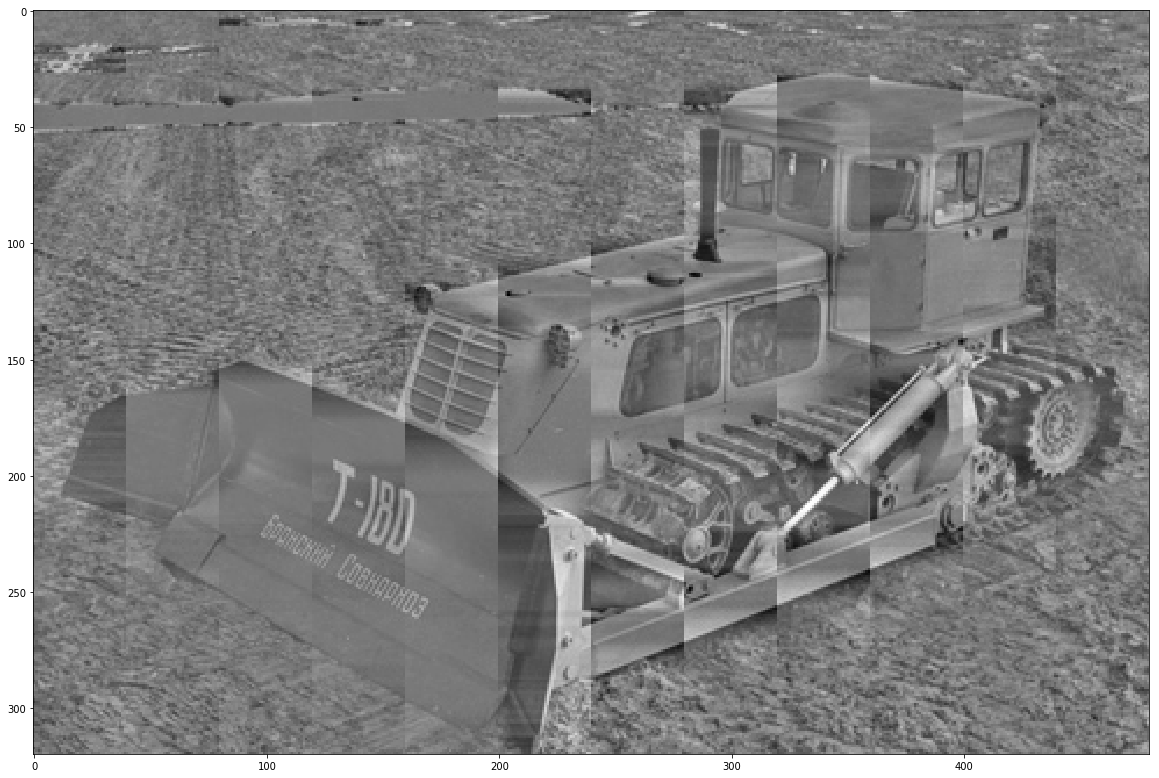

In [261]:
# Выводим картинку
plt.figure(figsize=(20,15))
plt.imshow(image2, cmap = 'gray')

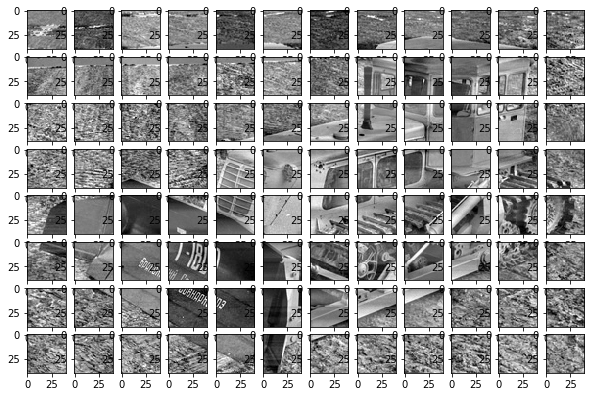

In [262]:
# Выводим базисные вектора
plot_images_table(reconstr, 12)

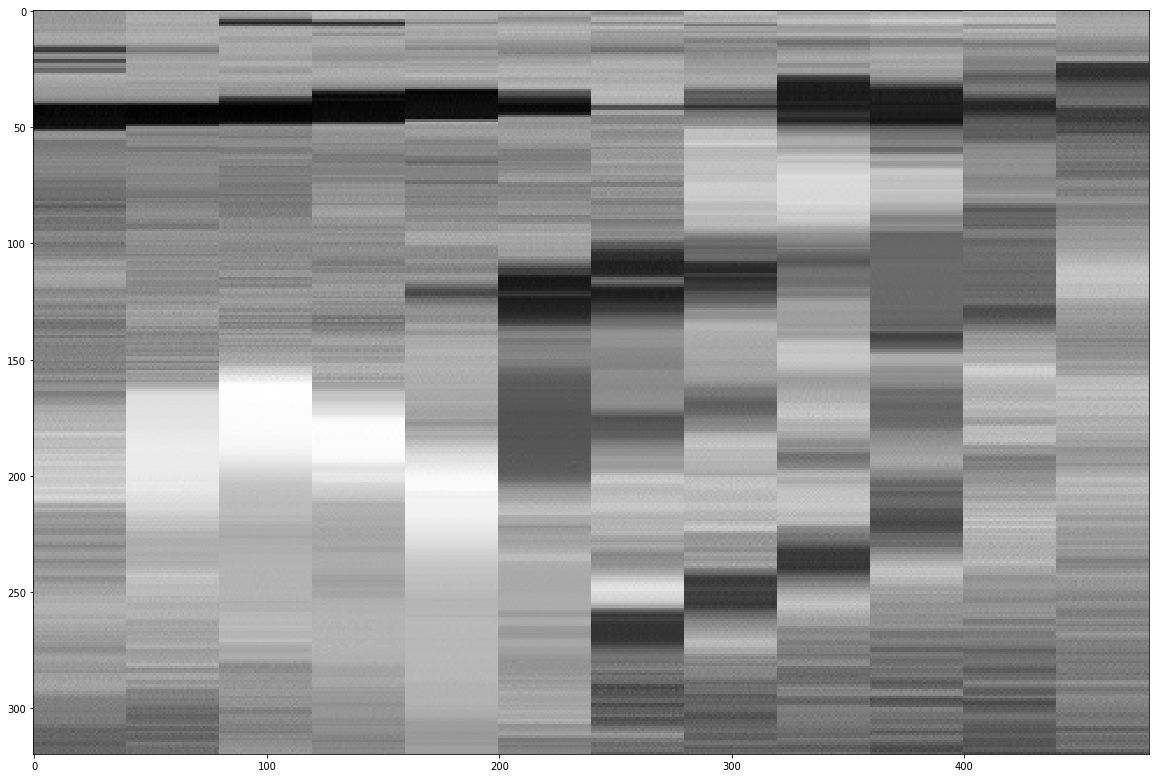

In [263]:
# Эксперименты
plt.figure(figsize=(20,15))
plt.imshow(image2-np.mean(np_image,axis=2), cmap='gray')

original entropy: 2.7385851300628605
transformed entropy: 1.5795138321465225
entropy loss: 1.159071297916338

data size before 460800 after 960
compression ratio 480.0


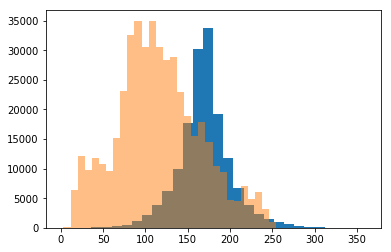

In [264]:
import scipy.stats
def softmax(x):
    return np.power(x,2.1828)/sum(np.power(x,2.1828))
r = image2.flatten()
r-=min(r)
o = np.array(np_image).flatten()
dist_transformed = plt.hist(r,bins=30)[0]
dist_orig = plt.hist(o,alpha=0.5,bins=30)[0]
dist_transformed=softmax(dist_transformed)
dist_orig=softmax(dist_orig)

e1 = scipy.stats.entropy(dist_orig)
e2=scipy.stats.entropy(dist_transformed)
print('original entropy:',e1)
print('transformed entropy:',e2)
print('entropy loss:',e1-e2)

print()
print('data size before %i after %i'%(len(o),len(T.flatten())))
print('compression ratio',len(o)/len(T.flatten()))